In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.special import logsumexp
from matplotlib import cm
import arviz as az
import pymc as pm

# Assignment 1: Babies

In [3]:
babies = pd.read_csv('babies.csv').sample(300, random_state=11)

In [4]:
month_obs = babies["Month"].values # x variable
length_obs = babies["Length"].values # y variable

## Problem and data

The length of human babies $y$ increase with the month from birth $x$ of the baby. For simplicity, we hypothize a *linear* dependency between $x$ and $y$, see scatterplot below.

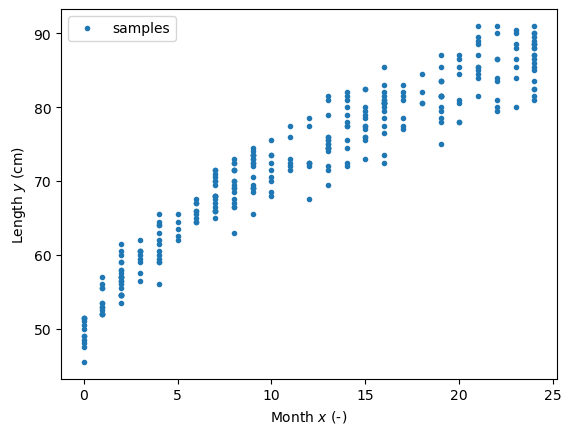

In [5]:
fig, ax = plt.subplots()
ax.plot(babies["Month"], babies["Length"], 'C0.', alpha=1.0, label="samples")
#ax.plot(0, alpha, "r*", label="alpha")
ax.set_ylabel("Length $y$ (cm)")
ax.set_xlabel("Month $x$ (-)")
plt.legend();

While the linear hypotesis seems reasonable, the points do not lie exactly on a line. In order to better characterize the data, we introduce the following probabilistic assumptions:



1. The average of the baby length $y_{\mu}$ at a given month $x$ is linear with intercept and slope coefficients 
   $\alpha$ and $\beta$, respectively:  $y_{\mu} = \alpha + \beta x$

2. The actual baby length is Gaussian with mean $y_{\mu}$ and standard deviation $\sigma$
3. The prior probability of $\beta$ is Gaussian with mean $0$ and standard deviation $\sigma_\beta=0.5$
4. The prior probability of $\sigma$ is a Half-Normal with standard deviation $\sigma_\sigma=1.0$
5. The intercept coefficient $\alpha$ is considered known and equal to $55.0$
6. Probabilities of different observations are independent of each other, given  \beta, \sigma$


Note: Condition 5 is rather artificial. It has been introduced here to limit the number of random variables and allow implementation of different approximate inference techniques.

In [11]:
alpha = babies[babies["Month"] == 0]["Length"].mean()

In [12]:
# Probabilistic model constants
alpha = babies[babies["Month"] == 0]["Length"].mean()
sigma_sigma = 1.0
sigma_beta = 0.5

## 1.1: Probabilistic model

* Derive and comment the full probabilistic model.

Putting together the probabilistic assumptions 1-3, we obtain:

\begin{align*}
y_i &\sim \mathcal{N}(\alpha + \beta x_i, \sigma)\\
\beta &\sim \mathcal{N}(0, \sigma_\beta)\\
\sigma &\sim |\mathcal{N}|(\sigma_\sigma)\\
\alpha &= 55.0
\end{align*}

Furthermore, according to assumption 4:

$$f(y|\theta) = \prod_i f(y_i|\theta)$$

## 1.2: Maximum Likelihood estimation 


* Derive an analytical expression of the likelihood function $\mathcal{L}(\beta, \sigma) = f(y|\beta, \sigma)$.

The likelihood function $\mathcal{L}(\beta, \sigma)$ is $P(y|\beta, \sigma)$, seen as a function of $\beta, \sigma$, with $y$ fixed to the observed outcome. <br/>Since the individual observations $y_i$ are independent, we have:

$$\mathcal{L}(\theta) = f(y|\theta) = \prod_{i=1}^N \frac{1}{\sigma \sqrt{2\pi}} 
e^{-\frac{1}{2} \bigg( \frac{y_i - (\alpha + \beta x_i)}{\sigma} \bigg )^2 }  $$

* Derive an analytical expression of the log-likelihood function $\ell(\beta, \sigma) = \log P(y|\beta, \sigma)$.

\begin{align}\ell(\beta, \sigma) &= \sum_{i=1}^N -log(\sigma) -1/2 \log(2\pi) -\frac{1}{2}\bigg( \frac{y_i - (\alpha + \beta x_i)}{\sigma} \bigg )^2\\
&= -\frac{N}{2} \log (2\pi) -N\log \sigma - \frac{1}{2 \sigma^2}\sum_{i=1}^{N} \big{(} y_i - (\alpha + \beta x_i)  \big{)} ^2
\end{align}

* Write a Python function corresponding to the log-likelihood function $\ell(\beta, \sigma)$. You may ignore additive factors which do not depend on $\beta, \sigma$.

In [19]:
#month_obs.shape[0]

In [13]:
def log_lik(beta, sigma):
    x = month_obs
    #x = np.sqrt(babies["Month"].values)
    y = length_obs  
    y_mu = alpha + beta*x
    N = x.shape[0]
    log_lik = -N/2*np.log(2*np.pi) - N*np.log(sigma) -1/(2*sigma**2) * np.sum((y - y_mu)**2)
    return log_lik

* Visualize the log-likelihood function $\ell(\beta, \sigma)$ in 2D

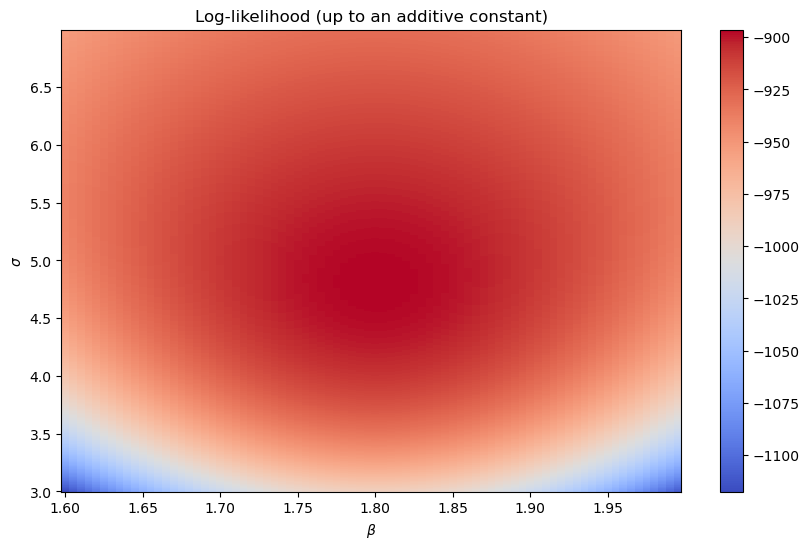

In [30]:
dbeta = 0.005
dsigma = 0.005
b_min, b_max = 1.6, 2.0
s_min, s_max = 3.0, 7.0
BETA = np.arange(b_min, b_max, dbeta)
SIGMA = np.arange(s_min, s_max, dsigma)


BB, SS = np.meshgrid(BETA, SIGMA, indexing='xy')
BBSS = np.stack((BB, SS), axis=-1)

LL = np.empty((SIGMA.shape[0], BETA.shape[0]))
for i in range(SIGMA.shape[0]):
    for j in range(BETA.shape[0]):
        LL[i, j] = log_lik(BETA[j], SIGMA[i])
    
fig, ax = plt.subplots(figsize=(10, 6))
c = ax.pcolormesh(BB, SS, LL, cmap=cm.coolwarm, shading='auto')

fig.colorbar(c, ax=ax)
ax.set_title(f"Log-likelihood (up to an additive constant)");
ax.set_xlabel(r"$\beta$");
ax.set_ylabel(r"$\sigma$");

* Obtain the maximum likelihood estimate $\beta^{\rm ml}, \sigma^{\rm ml}$

Hint: choose a good point to initialize the optimization

In [31]:
from scipy.optimize import minimize

log_lik_theta = lambda theta: log_lik(theta[0], theta[1])
nll_theta = lambda theta: -log_lik_theta(theta) # negative log-likelihood function.
res = minimize(nll_theta, x0=[1.5, 1.5])
theta_ml = res.x

In [32]:
theta_ml

array([1.80081555, 4.80254695])

* Visualize the log-likelihood together with the maximum likelihood estimate

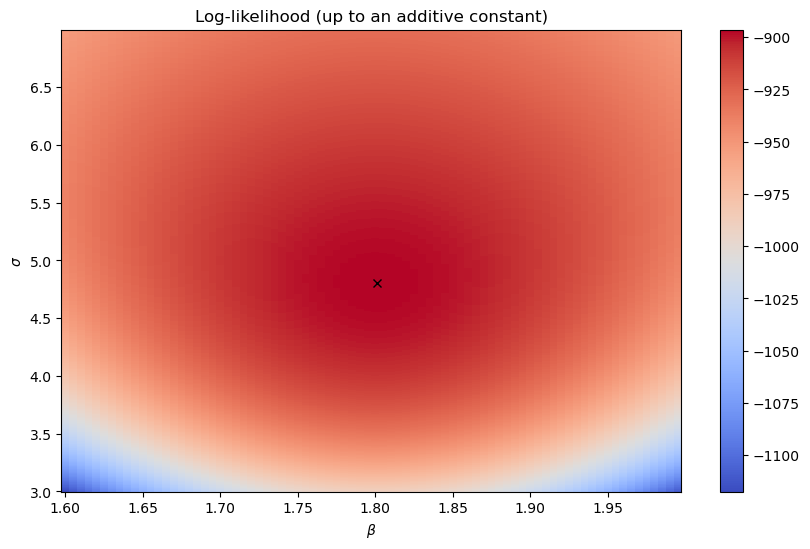

In [33]:
fig, ax = plt.subplots(figsize=(10, 6))
c = ax.pcolormesh(BB, SS, LL, cmap=cm.coolwarm, shading='auto')
plt.plot(theta_ml[0], theta_ml[1], "kx")
fig.colorbar(c, ax=ax)
ax.set_title(f"Log-likelihood (up to an additive constant)");
ax.set_xlabel(r"$\beta$");
ax.set_ylabel(r"$\sigma$");

* Visualize the *likelihood* function $\mathcal{L}(\sigma, \beta)$ in 2D up to a multiplicative constant

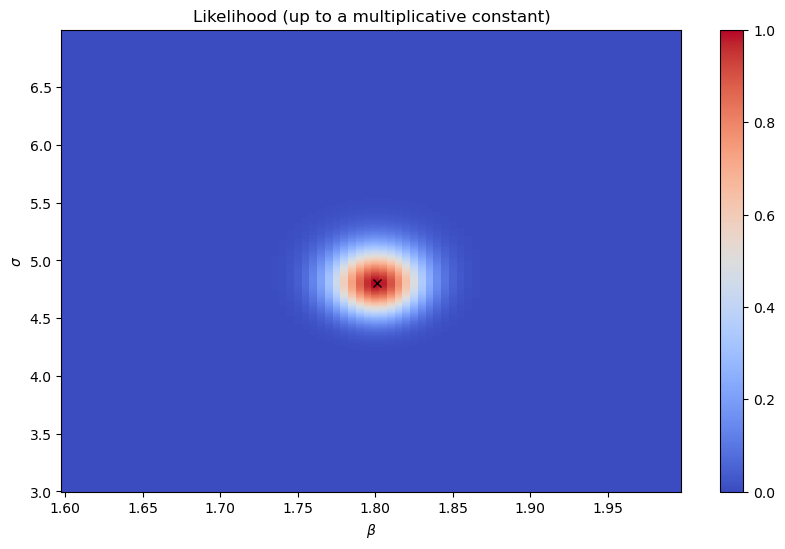

In [34]:
LIK_SC = np.exp(LL - np.max(LL)) # scaled to max_i LL_i = 1
#LIK_SC = np.exp(LL - logsumexp(LL)) # scaled to sum_i LL_i = 1 
#LIK_SC = np.exp(LL) # no scaling, dangerous numerically. Fails if we have around 250 data points

fig, ax = plt.subplots(figsize=(10, 6))
c = ax.pcolormesh(BB, SS, LIK_SC, cmap=cm.coolwarm, shading='auto')
plt.plot(theta_ml[0], theta_ml[1], "kx")
fig.colorbar(c, ax=ax)
ax.set_title(f"Likelihood (up to a multiplicative constant)");
ax.set_xlabel(r"$\beta$");
ax.set_ylabel(r"$\sigma$");

## 1.2: Maximum A Posteriori Estimation

* Derive an analytical expression of the posterior $f(\theta | y)$, up to a *multiplicative* factor that does not depend on $\beta, \sigma$. 

Hint: exploit the already-obtained likelihood and the functional form of the Gaussian pdf.

$$f(\theta | y) = \frac{P(y | \theta) f(\theta)}{P(y)} \propto \mathcal{L}(\theta)
\exp\left(-\frac{1}{2} \frac{\beta^2}{\sigma^2_\beta} \right )
\exp\left(-\frac{1}{2} \frac{\sigma^2}{\sigma^2_\sigma} \right ) $$

* Derive an analytical expression of the log-posterior $\log f(\theta | y)$, up to an *additive* factor that does not depend on $\beta, \sigma$. 


$$\log f(\theta | y) = \log \frac{P(y | \theta) f(\theta)}{P(y)} = \log P(y | \theta) + \log f(\beta) + \log f(\sigma) - \log P(y) $$

Thus, 

$$\log f(\theta | y) = \ell(\theta) -\frac{1}{2} \frac{\beta^2}{\sigma_\beta^2} -\frac{1}{2} \frac{\sigma^2}{\sigma_\sigma^2} $$

* Write the log-posterior (up to an additive factor) as Python functions.

In [35]:
def log_post_unscaled(beta, sigma):
    log_lik_val = log_lik(beta, sigma)
    return log_lik_val -0.5*beta**2/sigma_beta**2 -0.5* sigma**2/sigma_sigma**2

* Compute the maximum a posteriore estimate $\beta^{\rm MAP}, \sigma^{\rm MAP}$.

In [36]:
minus_logpost = lambda theta: -log_post_unscaled(theta[0], theta[1])
res = minimize(minus_logpost, x0=[1.4, 2])
theta_map = res.x

In [37]:
theta_map

array([1.79810209, 4.63916874])

* Visualize the MAP estimate together with the log-posterior in 2D. Comment the results.

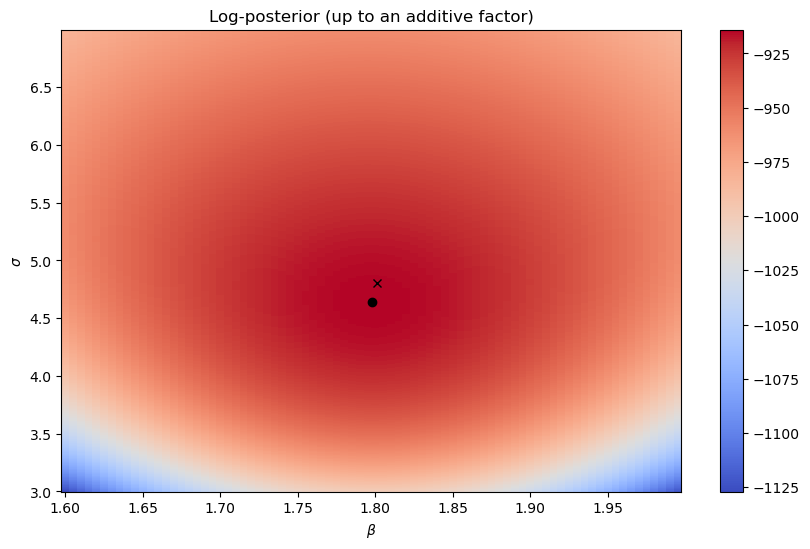

In [38]:
LP_UNSC = np.empty((SIGMA.shape[0], BETA.shape[0]))
for i in range(SIGMA.shape[0]):
    for j in range(BETA.shape[0]):
        LP_UNSC[i, j] = log_post_unscaled(BETA[j], SIGMA[i])

fig, ax = plt.subplots(figsize=(10, 6))
c = ax.pcolormesh(BETA, SIGMA, LP_UNSC, cmap=cm.coolwarm, shading='auto')
plt.plot(theta_ml[0], theta_ml[1], "kx")
plt.plot(theta_map[0], theta_map[1], "ko")
fig.colorbar(c, ax=ax)
ax.set_title(f"Log-posterior (up to an additive factor)");
ax.set_xlabel(r"$\beta$");
ax.set_ylabel(r"$\sigma$");

## 1.3 Brute-force posterior estimation

* Compute a gridding approximation of the *normalized* posterior, with the correct normalization constant. Explain the passages.

We have:
    $$ \tilde f(\theta | y) = \mathcal{L}(\theta) \exp\left(-\frac{1}{2} 
(\theta - \mu)^{\top} \Sigma_0^{-1} (\theta - \mu)^{\top} \right) = Z f(\theta | y),$$
where $Z$ is the to-be-determined normalization constant and it must be chosen such that:
$$\iint f(\theta | y) d\alpha\; d\beta = 1.$$
Thus,
$$Z = \iint f(\theta | y) d\alpha\; d\beta.$$

The integral above is intractable, but a gridding approximation may be used. Using an equi-spaced gridding, a Riemann Sum approximation is:

$$Z \approx \Delta \alpha \Delta \beta \sum_i f(\theta_i | y),$$

where $\Delta \alpha$ and $\Delta \beta$ are the discretization steps of the 2D grid and $\theta_i$ are the grid points.

In [39]:
# Fast solution, if we know all the tricks...
P_SC = np.exp(LP_UNSC - logsumexp(LP_UNSC))
P_SC = P_SC/(dbeta * dsigma)

* Visualize the *normalized* posterior, together with the ML and MAP estimates

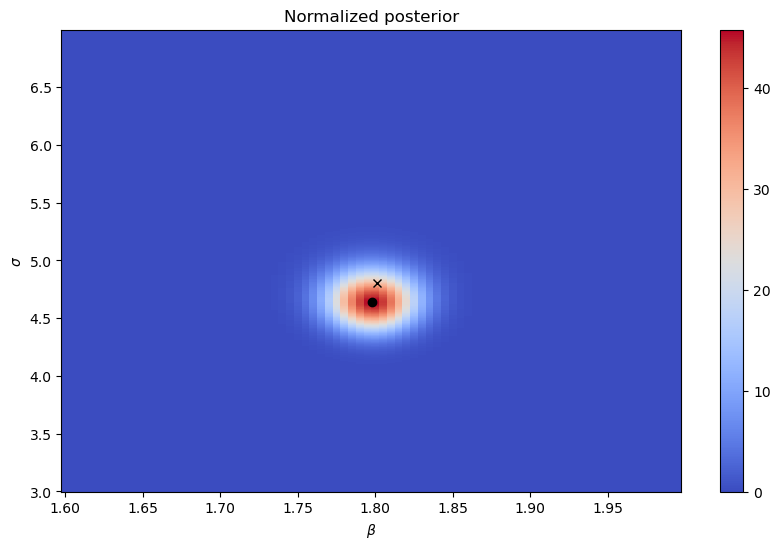

In [40]:
fig, ax = plt.subplots(figsize=(10, 6))
c = ax.pcolormesh(BETA, SIGMA, P_SC, cmap=cm.coolwarm, shading='auto')
plt.plot(theta_ml[0], theta_ml[1], "kx")
plt.plot(theta_map[0], theta_map[1], "ko")
fig.colorbar(c, ax=ax)
ax.set_title(f"Normalized posterior");
ax.set_xlabel(r"$\beta$");
ax.set_ylabel(r"$\sigma$");

* Using the grid-based approximation of the posterior, compute the posterior mean of $\beta$ and $\sigma$.

By definition, we have:

$$E[\beta] = \iint \beta p(\beta, \sigma | y) d\beta\; d\sigma.$$

Using the grid-based approximation above:

$$E[\beta] = \Delta \beta \Delta \sigma \sum \beta_i p(\beta_i, \sigma_i | y).$$

Similar formulas apply for $E[\sigma]$. Software implementation below

In [41]:
beta_mean = np.sum(BB*P_SC)*dbeta*dsigma
sigma_mean = np.sum(SS*P_SC)*dbeta*dsigma
beta_mean, sigma_mean

(1.7980712369332048, 4.662112319880938)

This is yet another meaningful point estimate of the latent variables $\beta, \sigma$ 

## 1.4 Monte-carlo estimation

* Obtain a sample-based approximation of the posterior $f(\beta, \sigma | y)$ using pymc.

In [42]:
with pm.Model() as model_baby_linear:
    beta = pm.Normal('beta', sigma=sigma_beta)
    
    length_mean = pm.Deterministic("length_mean", alpha  + beta * month_obs)
    sigma = pm.HalfNormal("sigma", sigma=sigma_sigma)

    length = pm.Normal("length", mu=length_mean, sigma=sigma, observed=length_obs)
    inf_data = pm.sample(draws=10_000, tune=4000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 4_000 tune and 10_000 draw iterations (16_000 + 40_000 draws total) took 2 seconds.


In [43]:
az.summary(inf_data, var_names=["beta", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,1.798,0.019,1.762,1.835,0.000,0.000,37262.0,29138.0,1.0
sigma,4.662,0.178,4.336,5.006,0.001,0.001,35868.0,28331.0,1.0


In [44]:
inf_data_flat = inf_data.posterior.stack(sample=("chain", "draw"))

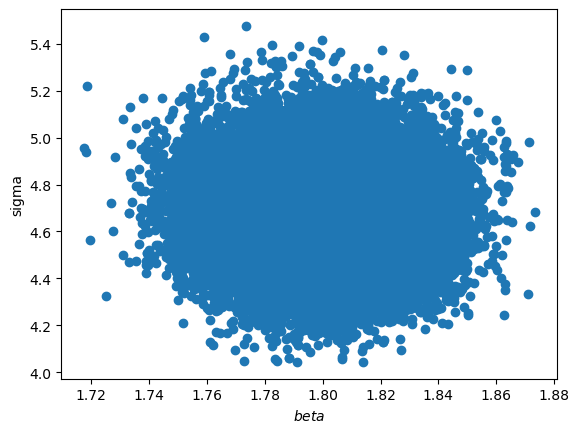

In [45]:
plt.scatter(inf_data_flat["beta"], inf_data_flat["sigma"])
plt.xlabel("$beta$")
plt.ylabel("sigma");

* Obtain a sample-based approximation of the posterior $f(\beta, \sigma | y)$ by implementing the Metropolis algorithm from scratch.

In [46]:
def p_ratio_fun(beta_propose, sigma_propose, beta_previous, sigma_previous):
    log_p_previous = log_post_unscaled(beta_previous, sigma_previous)
    log_p_propose = log_post_unscaled(beta_propose, sigma_propose)
    log_p_ratio = log_p_propose - log_p_previous # log(p_prop/p_prev) = log(p_prop) - log(p_prev)
    p_ratio = np.exp(log_p_ratio)
    return p_ratio

In [47]:
p_ratio_fun(beta_propose=1.5, sigma_propose =1.5, beta_previous=1.4, sigma_previous =1.4)

/var/folders/w7/h67z1rn941j1p0m51k08d9xc0000gp/T/ipykernel_8725/253049672.py:5: RuntimeWarning: overflow encountered in exp
  p_ratio = np.exp(log_p_ratio)


inf

Let us run a Metropolis algorithm to sample from the posterior. The `p_ratio_fun` function is all we need!

In [48]:
draws = 100_000 # mc draws
tune = 10_000 # mc burn-in 
beta_0 = 1.8 # initial value for beta
sigma_0 = 4.6 # initial value for sigma
sigma_prop_beta = 0.1
sigma_prop_sigma = 0.1

beta_step = beta_0
sigma_step = sigma_0

betas = []
sigmas = []

for idx in range(draws+tune):
    betas.append(beta_step)
    sigmas.append(sigma_step)
                  
    beta_prop = beta_step + sigma_prop_beta * np.random.randn()
    sigma_prop = sigma_step + sigma_prop_sigma * np.random.randn()
  
    p_ratio = p_ratio_fun(beta_prop, sigma_prop, beta_step, sigma_step)
    accept_prob = np.minimum(1.0, p_ratio)
    accept = (np.random.rand() < accept_prob)
    
    if accept:
        beta_step = beta_prop
        sigma_step = sigma_prop
                  
betas = np.stack(betas)
sigmas = np.stack(sigmas)
thetas = np.c_[betas, sigmas]
thetas = thetas[tune:, :]

In [49]:
np.mean(thetas, axis=0)

array([1.79793642, 4.66569302])

In [50]:
np.cov(thetas.transpose())

array([[ 3.74661599e-04, -5.46518657e-05],
       [-5.46518657e-05,  3.27760625e-02]])

In [51]:
np.sum(BB*P_SC)*dbeta*dsigma, np.sum(SS*P_SC)*dbeta*dsigma

(1.7980712369332048, 4.662112319880938)

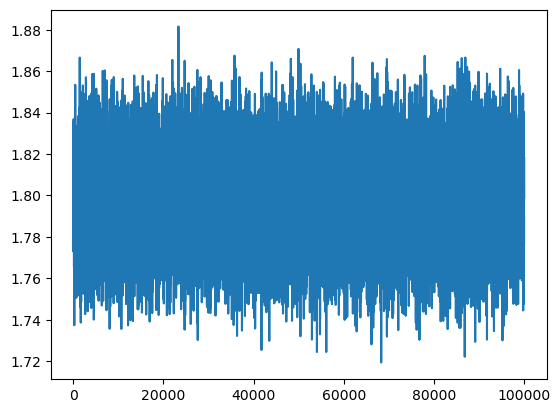

In [52]:
plt.plot(thetas[:,0])#px.scatter(thetas[:, 0])

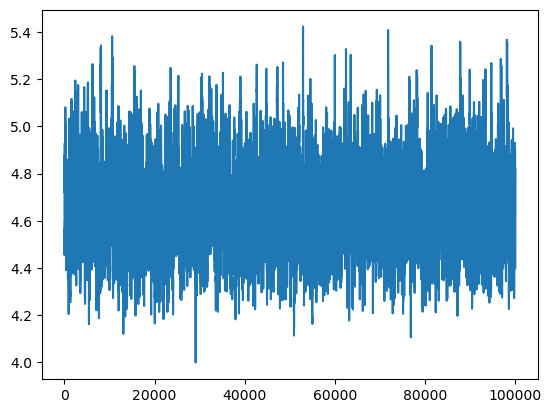

In [53]:
plt.plot(thetas[:, 1])

* Compare the posterior estimation results obtained with the different techniques (brute-force, pymc, metropolis)

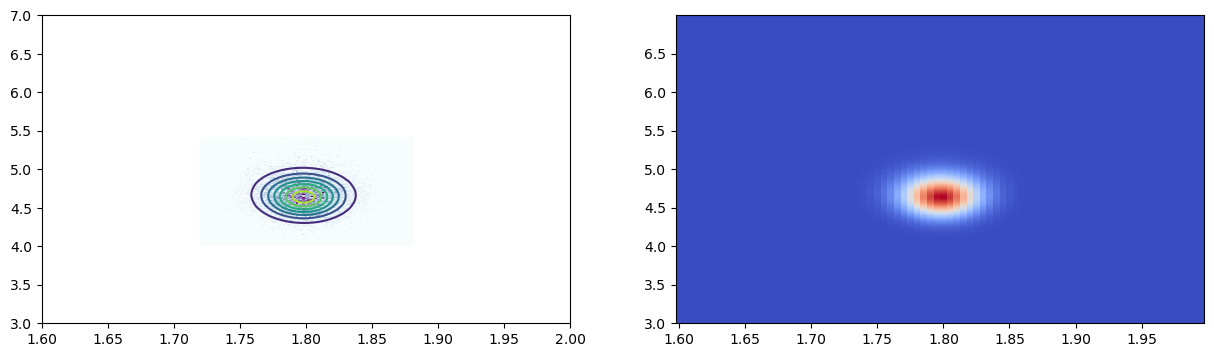

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
ax[0].hist2d(x=thetas[:, 0], y=thetas[:, 1], bins=100, cmap=plt.cm.BuPu)
ax[0].set_xlim([b_min, b_max]);
ax[0].set_ylim([s_min, s_max]);
ax[0].contour(BB, SS, P_SC); #, levels=[5, 15,  95]); # levels=[5, 15, 25, 35, 45, 55, 65, 75, 85, 95])
c = ax[1].pcolormesh(BB, SS, P_SC, cmap=cm.coolwarm, shading='auto')

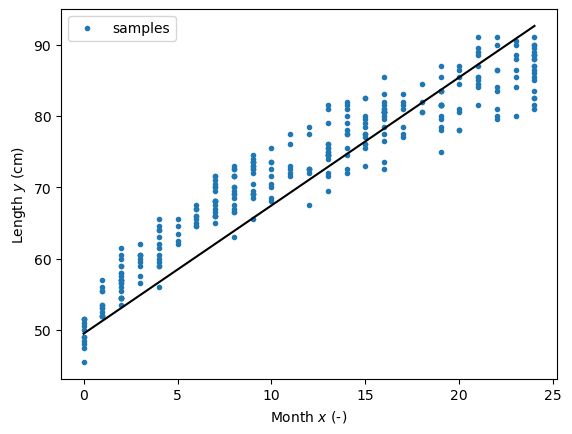

In [57]:
x_mdl = np.arange(25)
y_mdl = alpha + beta_mean*x_mdl # basic deterministic model (just to check)
fig, ax = plt.subplots()
ax.plot(babies["Month"], babies["Length"], 'C0.', alpha=1.0, label="samples")
ax.plot(x_mdl, y_mdl, "k")
ax.set_ylabel("Length $y$ (cm)")
ax.set_xlabel("Month $x$ (-)")
plt.legend();